In [22]:
!pip install -r requirements.txt

In [23]:
import nest_asyncio
nest_asyncio.apply()
import asyncio

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, display
import time

bridge_trajs = np.load("assets/bridge_v2_10_trajs.npy", allow_pickle=True)

In [25]:
from vlm_autoeval_robot_benchmark.utils.ecot_primitives import ecot_primitive_movements, inverse_ecot_primitive_movements

In [26]:
def show_trajectory_video(descriptors, delay=0.2):
    """Show observations as a video with delay between frames."""
    plt.figure(figsize=(10, 10))
    for i, obs in enumerate(descriptors["obs"]):
        clear_output(wait=True)
        plt.imshow(obs)
        title = f"Frame {i} - {descriptors['task_language_instruction']}"
        for k,v in descriptors['moves'][i].items():
            title += f"\n{k} - {v}"
        plt.title(title)
        plt.axis('off')
        display(plt.gcf())
        time.sleep(delay)
    plt.close()

In [27]:
def repackage_to_episode(traj):
    steps = []
    for i in range(len(traj["observations"])):
        step = {}
        step["observation"] = traj["observations"][i]
        step["action"] = traj["actions"][i]
        steps.append(step)
    return dict(steps=steps)

In [28]:
def get_descriptors(traj):
    move_primitives = ecot_primitive_movements.get_move_primitives_episode(repackage_to_episode(traj), threshold=0.00)
    move_primitives = [dict(ecot=move) for move in move_primitives]
    obs_list = [t["images0"] for t in traj["observations"]]  # list of obs
    gt_actions = traj["actions"]  # list of ground truth actions
    task_language_instruction = traj["language"][0] if "language" in traj else None
    return dict(moves=move_primitives, obs=obs_list, gt_actions=gt_actions, task_language_instruction=task_language_instruction)

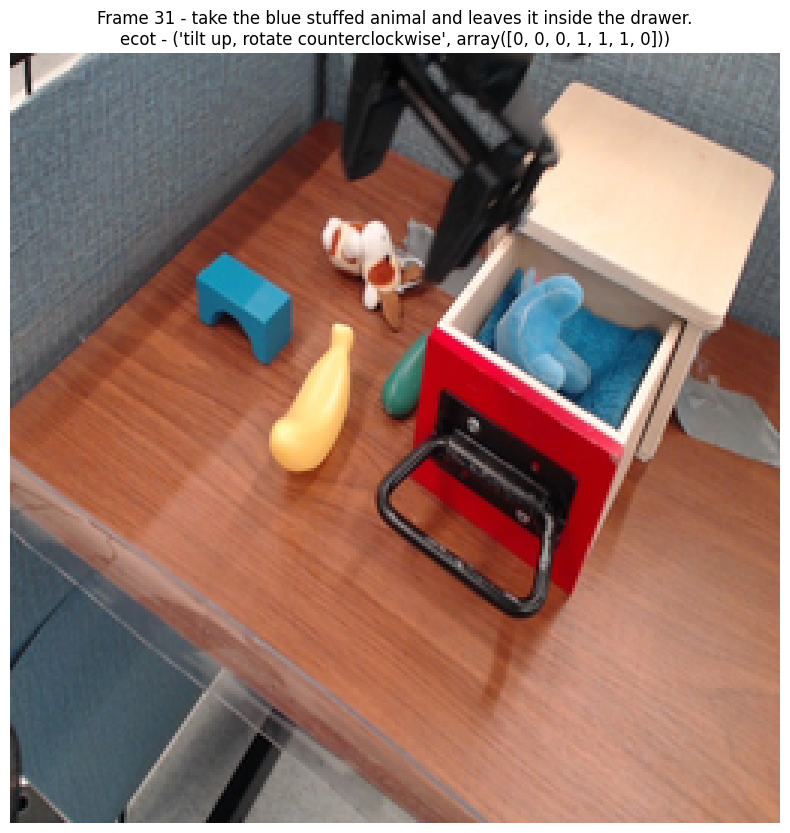

In [29]:
traj_idx = 4  # Change this to visualize different trajectories
episode_descriptors = get_descriptors(bridge_trajs[traj_idx])
show_trajectory_video(episode_descriptors, delay=0.15)

In [30]:
from primitive_moves_tester import run_test, print_test_results

In [31]:
traj = bridge_trajs[traj_idx]
episode_descriptors = get_descriptors(bridge_trajs[traj_idx])

In [32]:
import io
import numpy as np
from PIL import Image

def numpy_array_to_png_bytes(arr: np.ndarray) -> bytes:
    """
    Convert a NumPy array to PNG file bytes, as if it was saved as a PNG and then read with fp.read()
    
    Args:
        arr: NumPy array with shape (height, width, 3) and dtype uint8
        
    Returns:
        PNG file bytes
    """
    # Ensure the array is the right shape and type
    if len(arr.shape) != 3 or arr.shape[2] != 3:
        raise ValueError(f"Expected array with shape (height, width, 3), got {arr.shape}")
    
    if arr.dtype != np.uint8:
        arr = arr.astype(np.uint8)
    
    # Convert the NumPy array to a PIL Image
    img = Image.fromarray(arr)
    
    # Create a BytesIO object to store the image bytes
    buffer = io.BytesIO()
    
    # Save the image to the BytesIO object as PNG
    img.save(buffer, format="PNG")
    
    # Get the bytes from the BytesIO object
    png_bytes = buffer.getvalue()
    
    return png_bytes

In [33]:
sub_episode_descriptors = dict()
for k,v in episode_descriptors.items():
    if isinstance(v, list):
        sub_episode_descriptors[k] = v[::5]
    else:
        sub_episode_descriptors[k] = v

In [34]:
model = "gpt-4o"
env_desc = "You are looking at a wooden desk with a black robot arm. The desk has a drawer with a handle and some objects on it."
task_desc = sub_episode_descriptors["task_language_instruction"]
img_bytes = [numpy_array_to_png_bytes(img) for img in sub_episode_descriptors["obs"]]

In [35]:
async def run_all_tests(model, env_desc, task_desc, img_bytes_list, num_samples=1):
    tasks = [
        run_test(model, env_desc, task_desc, img_bytes, num_samples=num_samples)
        for i, img_bytes in enumerate(img_bytes_list)
    ]
    results = await asyncio.gather(*tasks)
    return results

# Run all tests in parallel
results = asyncio.run(run_all_tests(
    model,
    env_desc,
    task_desc,
    img_bytes,  # assuming img_bytes is your list of image bytes
    num_samples=1
))
for res in results:
    print_test_results(res)

TypeError: run_test() missing 1 required positional argument: 'key'

In [21]:
results[0][0][0]

for t, res in enumerate(results):
    single_res = res[0]
    action_text = [single_res['answer'][k] for k in ['x', 'y', 'z', 'tilt', 'roll', 'yaw', 'gripper']]
    sub_episode_descriptors['moves'][t]['vlm'] = action_text



{'index': 0,
 'description': "The scene depicts a wooden desk with a black robot arm positioned over it. The desk contains several objects, including a blue stuffed animal, a banana, and a dog toy. There's also a red drawer slightly open with a handle on the right side. The task is to pick up the blue stuffed animal and place it inside the drawer. Currently, the robot arm is positioned near the blue stuffed animal, but it has not yet made contact or grasped it.\n\nFor the next action, the robot should focus on aligning its gripper to pick up the blue stuffed animal. This involves adjusting its position slightly forward and to the right, bringing the gripper closer to the object. The robot should also adjust its height and align the gripper's tilt and rotation to prepare for grasping.",
 'answer': {'x': ['forward',
   'I chose forward because the robot needs to move slightly towards the front to align with the blue stuffed animal.'],
  'y': ['right',
   'I chose right because the robot 